In [1]:
import torch
from train import train_model
from dataset.utils import *
from utils import *
import numpy as np
import pickle
import time

In [2]:
batch_size = 128
def redefine_train_parameters():
    global device, epochs, learning_rate, loss_lr, num_classes, embedding_size
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    epochs = 20
    learning_rate = 0.001
    loss_lr = 0.01
    num_classes = get_num_classes(train_dataset)
    embedding_size = 512

In [3]:
def train(train_dataset, test_dataset, verbose=0, pretrained=True, save_path=None, model_name='resnet50', optimizer='adam', loss_func_name='proxy_anchor', use_loss_optimizer=False, drop_last=False):
    train_loader = load_dataset(train_dataset, batch_size, shuffle=True, drop_last=drop_last)
    test_loader = load_dataset(test_dataset, batch_size, shuffle=False, drop_last=drop_last)
    model = train_model(model_name=model_name,
                    loss_func_name=loss_func_name,
                    num_classes=num_classes,
                    dataloader=train_loader,
                    optimizer=optimizer,
                    embedding_size=embedding_size,
                    epochs=epochs,
                    learning_rate=learning_rate,
                    verbose=verbose,
                    use_loss_optimizer=use_loss_optimizer,
                    save_path=save_path)
    return model, train_loader, test_loader

In [4]:
def cross_validate(dataset, k=10):
    global r1,r2,r4,r8,r16,r32
    np.random.shuffle(np.array(dataset))
    k=k
    split_len = len(dataset)//k
    max_index = split_len*k
    r1,r2,r4,r8,r16,r32= [],[],[],[],[],[]
    for fold in range(k):
        print(f'''----------
fold {fold+1}:''')
        start = split_len * fold
        train_dataset = dataset[:start] + dataset[start + split_len:max_index]
        test_dataset = dataset[start:start+split_len]
        train_loader = load_dataset(train_dataset, batch_size, shuffle=True)
        test_loader = load_dataset(test_dataset, batch_size, shuffle=False)
        model = train_model(model_name='resnet50',
                        loss_func_name='proxy_anchor',
                        num_classes=num_classes,
                        dataloader=train_loader,
                        epochs=epochs,
                        learning_rate=learning_rate,
                        verbose=0)
        recall = evaluate_cos(model, test_loader)
        r1.append(recall[0])
        r2.append(recall[1])
        r4.append(recall[2])
        r8.append(recall[3])
        r16.append(recall[4])
        r32.append(recall[5])

In [5]:
def avg_recall(name, percent=False):
    print(f'''Average Recall {name}:''')
    
    if percent:
        print(f'''R@1 : {np.mean(r1)*100}
R@2 : {np.mean(r2)*100}
R@4 : {np.mean(r4)*100}
R@8 : {np.mean(r8)*100}
R@16 : {np.mean(r16)*100}
R@32 : {np.mean(r32)*100}''')
    
    else:
        print(f'''R@1 : {np.mean(r1)}
R@2 : {np.mean(r2)}
R@4 : {np.mean(r4)}
R@8 : {np.mean(r8)}
R@16 : {np.mean(r16)}
R@32 : {np.mean(r32)}''')

In [6]:
def save_output(output, name):
    try:
        data = load_output()
    except:
        data = dict()
    data[name] = output
    with open('recall.pkl', 'wb') as file:
        pickle.dump(data, file)
        
def load_output():
    with open('recall.pkl', 'rb') as file:
        return pickle.load(file)

In [ ]:
train_dataset = make_dataset('LFW', split='train', image_size=0, random_resized_crop=125, random=1, face_detection=False, unsharp=1, unsharp_amount=1, unsharp_radius=1)
norm_mean,norm_std=normalize_dataset([train_dataset])
train_dataset = make_dataset('LFW', split='train', image_size=0, face_detection=False, normalize=1, norm_mean=norm_mean,norm_std=norm_std, random_resized_crop=125, random=1, unsharp=1, unsharp_amount=1, unsharp_radius=1)
test_dataset =  make_dataset('LFW', split='test',  image_size=0, crop=125, face_detection=False, normalize=1, norm_mean=norm_mean,norm_std=norm_std, unsharp=1, unsharp_amount=1, unsharp_radius=1)
redefine_train_parameters()
name='PA+Unsharp'
model, train_loader, test_loader = train(train_dataset,test_dataset,save_path=f'./saved_models/{name}.ptm')
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')
test_dataset = torchvision.datasets.LFWPairs(
    root='./data',
    split='test',
    download=True,
    transform=transforms.Compose([
        transforms.CenterCrop(125),
        UnsharpFilter(radius=1,amount=1),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean,norm_std)
    ])
)
labels,sim_scores = evaluate(model,test_dataset)
visualize(labels,sim_scores)

train_dataset = make_dataset('LFW', split='train', image_size=0, random_resized_crop=125, random=1, face_detection=False, unsharp=1, unsharp_amount=1, unsharp_radius=1, median_hsv=1, median_hsv_method='v', median_hsv_size=3)
norm_mean,norm_std=normalize_dataset([train_dataset])
train_dataset = make_dataset('LFW', split='train', image_size=0, face_detection=False, normalize=1, norm_mean=norm_mean,norm_std=norm_std, random_resized_crop=125, random=1, unsharp=1, unsharp_amount=1, unsharp_radius=1)
test_dataset =  make_dataset('LFW', split='test',  image_size=0, crop=125, face_detection=False, normalize=1, norm_mean=norm_mean,norm_std=norm_std, unsharp=1, unsharp_amount=1, unsharp_radius=1)
redefine_train_parameters()
name='PA+Unsharp'
model, train_loader, test_loader = train(train_dataset,test_dataset,save_path=f'./saved_models/{name}.ptm')
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')
test_dataset = torchvision.datasets.LFWPairs(
    root='./data',
    split='test',
    download=True,
    transform=transforms.Compose([
        transforms.CenterCrop(125),
        UnsharpFilter(radius=1,amount=1),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean,norm_std)
    ])
)
labels,sim_scores = evaluate(model,test_dataset)
visualize(labels,sim_scores)

In [8]:
train_dataset = make_dataset('LFW', split='train', image_size=0, random_resized_crop=125, random=1, face_detection=False)
norm_mean,norm_std=normalize_dataset([train_dataset])
train_dataset = make_dataset('LFW', split='train', image_size=0, face_detection=False, normalize=1, norm_mean=norm_mean,norm_std=norm_std, random_resized_crop=125, random=1)
test_dataset =  make_dataset('LFW', split='test',  image_size=0, crop=125, face_detection=False, normalize=1, norm_mean=norm_mean,norm_std=norm_std)
redefine_train_parameters()

Files already downloaded and verified
==> Computing mean and std..


100%|███████████████████████████████████████| 9525/9525 [04:32<00:00, 34.99it/s]


tensor([0.4616, 0.3910, 0.3397]) tensor([0.2253, 0.2041, 0.1949])
time elapsed:  272.31480956077576
Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_dataset = make_dataset('LFW', split='train', image_size=0, face_detection=False, random_resized_crop=100, random=1)
# norm_mean,norm_std=normalize_dataset([train_dataset])
norm_mean,norm_std=torch.tensor([0.4659, 0.3943, 0.3430]),torch.tensor([0.2248, 0.2036, 0.1948])
train_dataset = make_dataset('LFW', split='train', image_size=0, face_detection=False, normalize=1, norm_mean=norm_mean,norm_std=norm_std, random_resized_crop=100, random=1)
test_dataset =  make_dataset('LFW', split='test',  image_size=0, crop=100, face_detection=False, normalize=1, norm_mean=norm_mean,norm_std=norm_std)
redefine_train_parameters()
name='PA+Crop(100)'
model, train_loader, test_loader = train(train_dataset,test_dataset,save_path=f'./saved_models/{name}.ptm')
evaluate_cos(model,train_loader)
evaluate_cos(model,test_loader)
test_dataset = torchvision.datasets.LFWPairs(
    root='./data',
    split='test',
    download=True,
    transform=transforms.Compose([
        transforms.CenterCrop(100),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean,norm_std)
    ])
)
labels,sim_scores = evaluate(model,test_dataset)
visualize(labels,sim_scores)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/20]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/20]:   0%|          | 0/75 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

100%|███████████████████████████████████████████| 75/75 [04:03<00:00,  3.25s/it]


R@1 : 12.567
R@2 : 16.703
R@4 : 21.144
R@8 : 26.215
R@16 : 31.297
R@32 : 36.724
Average Recall train_PA:
R@1 : 0.12566929133858268
R@2 : 0.16703412073490814
R@4 : 0.21144356955380578
R@8 : 0.2621522309711286
R@16 : 0.31296587926509184
R@32 : 0.36724409448818895


100%|███████████████████████████████████████████| 29/29 [00:55<00:00,  1.92s/it]


R@1 : 14.132
R@2 : 19.606
R@4 : 26.160
R@8 : 32.497
R@16 : 38.916
R@32 : 45.146
Average Recall test_PA:
R@1 : 0.1413160733549083
R@2 : 0.19606256742179073
R@4 : 0.261596548004315
R@8 : 0.3249730312837109
R@16 : 0.38915857605177995
R@32 : 0.45145631067961167


Files already downloaded and verified


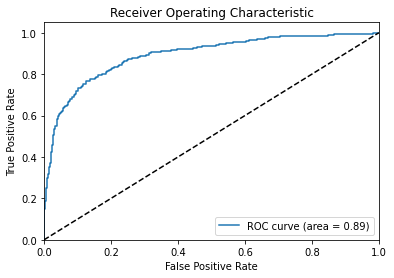

TAR@FAR:
    1%: 0.7240
  0.1%: 0.2980
 0.01%: 0.1480
0.001%: 0.1480
Accuracy: 0.819, Threshold: 0.7520571947097778


In [11]:
test_dataset = torchvision.datasets.LFWPairs(
    root='./data',
    split='test',
    download=True,
    transform=transforms.Compose([
        transforms.CenterCrop(125),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean,norm_std)
    ])
)
labels,sim_scores = evaluate(model,test_dataset)
visualize(labels,sim_scores)

In [74]:
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125)
redefine_train_parameters()
train_dataset2 = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125, random=True)
train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_dataset2])
test_dataset = make_dataset('LFW', split='test', image_size=100, face_detection=False, crop=125)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [75]:
name='PA+Crop(125)+Random'
model, train_loader, test_loader = train(train_dataset,test_dataset,save_path=f'./saved_models/{name}.ptm')

100%|█████████████████████████████████████████| 596/596 [00:35<00:00, 16.59it/s]


Finished Training, Time: 719.0705 Best loss: 6.4548


In [76]:
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125)
train_loader = load_dataset(train_dataset, batch_size=32, shuffle=True)
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

Files already downloaded and verified


100%|█████████████████████████████████████████| 298/298 [00:09<00:00, 32.86it/s]


R@1 : 66.562
R@2 : 66.919
R@4 : 67.171
R@8 : 67.402
R@16 : 67.570
R@32 : 67.769
Average Recall train_PA+Crop(125)+Random:
R@1 : 0.6656167979002625
R@2 : 0.6691863517060368
R@4 : 0.6717060367454069
R@8 : 0.6740157480314961
R@16 : 0.6756955380577427
R@32 : 0.6776902887139108


100%|█████████████████████████████████████████| 116/116 [00:03<00:00, 33.50it/s]


R@1 : 24.784
R@2 : 28.937
R@4 : 32.362
R@8 : 36.300
R@16 : 40.022
R@32 : 43.770
Average Recall test_PA+Crop(125)+Random:
R@1 : 0.24784250269687164
R@2 : 0.28937432578209277
R@4 : 0.32362459546925565
R@8 : 0.3629989212513484
R@16 : 0.4002157497303128
R@32 : 0.4377022653721683


In [ ]:
for radius,amount in [(1,1),(1,2),(1,3),(3,1),(3,2),(3,3),(5,1),(5,2),(7,1),(7,2),(10,1),(20,1)]:
    train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125,unsharp=1,unsharp_radius=radius,unsharp_amount=amount)
    redefine_train_parameters()
    train_dataset2 = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125, random=True, unsharp=1,unsharp_radius=radius,unsharp_amount=amount)
    train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_dataset2])
    test_dataset = make_dataset('LFW', split='test', image_size=100, face_detection=False, crop=125, unsharp=1,unsharp_radius=radius,unsharp_amount=amount)
    name=f'PA+Crop(125)+Random+Unsharp(radius={radius},amount={amount})'
    model, train_loader, test_loader = train(train_dataset,test_dataset,save_path=f'./saved_models/{name}.ptm')
    train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125,unsharp=1,unsharp_radius=radius,unsharp_amount=amount)
    train_loader = load_dataset(train_dataset, batch_size=32, shuffle=True)
    save_output(evaluate_cos(model,train_loader),f'train_{name}')
    r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
    avg_recall(f'train_{name}')
    save_output(evaluate_cos(model,test_loader),f'test_{name}')
    r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
    avg_recall(f'test_{name}')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


 61%|████████████████████████▉                | 362/596 [00:57<00:37,  6.28it/s]

In [ ]:
for size in [1,3,5,7,9]:
    train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125,unsharp=1,unsharp_radius=1,unsharp_amount=1,median_hsv=1,median_hsv_method='v',median_hsv_size=size)
    redefine_train_parameters()
    train_dataset2 = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125, random=True, unsharp=1,unsharp_radius=1,unsharp_amount=1,median_hsv=1,median_hsv_method='v',median_hsv_size=size)
    train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_dataset2])
    test_dataset = make_dataset('LFW', split='test', image_size=100, face_detection=False, crop=125, unsharp=1,unsharp_radius=1,unsharp_amount=1,median_hsv=1,median_hsv_method='v',median_hsv_size=size)
    name=f'PA+Crop(125)+Random+Unsharp(radius=1,amount=1)+MedianHSV(method=v,size={size})'
    model, train_loader, test_loader = train(train_dataset,test_dataset,save_path=f'./saved_models/{name}.ptm')
    train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125,unsharp=1,unsharp_radius=1,unsharp_amount=1,median_hsv=1,median_hsv_method='v',median_hsv_size=size)
    train_loader = load_dataset(train_dataset, batch_size=32, shuffle=True)
    save_output(evaluate_cos(model,train_loader),f'train_{name}')
    r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
    avg_recall(f'train_{name}')
    save_output(evaluate_cos(model,test_loader),f'test_{name}')
    r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
    avg_recall(f'test_{name}')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 596/596 [02:28<00:00,  4.00it/s]


Finished Training, Time: 2970.3397 Best loss: 6.4474
Files already downloaded and verified


100%|█████████████████████████████████████████| 298/298 [01:05<00:00,  4.57it/s]


R@1 : 68.178
R@2 : 68.367
R@4 : 68.588
R@8 : 68.745
R@16 : 68.861
R@32 : 68.966
Average Recall train_PA+Crop(125)+Random+Unsharp(radius=1,amount=1)+MedianHSV(method=v,size=1):
R@1 : 0.6817847769028872
R@2 : 0.6836745406824147
R@4 : 0.6858792650918635
R@8 : 0.6874540682414698
R@16 : 0.6886089238845144
R@32 : 0.6896587926509187


100%|█████████████████████████████████████████| 116/116 [00:25<00:00,  4.55it/s]


R@1 : 27.913
R@2 : 31.769
R@4 : 35.275
R@8 : 38.808
R@16 : 41.775
R@32 : 44.930
Average Recall test_PA+Crop(125)+Random+Unsharp(radius=1,amount=1)+MedianHSV(method=v,size=1):
R@1 : 0.279126213592233
R@2 : 0.31769147788565266
R@4 : 0.35275080906148865
R@8 : 0.38807982740021574
R@16 : 0.41774541531823084
R@32 : 0.44929881337648325
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


 29%|███████████▊                             | 172/596 [00:48<01:57,  3.62it/s]

In [ ]:
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=1,unsharp=1,unsharp_radius=1,unsharp_amount=1)
redefine_train_parameters()
train_dataset2 = make_dataset('LFW', split='train', image_size=100, face_detection=1, random=True, unsharp=1,unsharp_radius=1,unsharp_amount=1)
train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_dataset2])
test_dataset = make_dataset('LFW', split='test', image_size=100, face_detection=1, unsharp=1,unsharp_radius=1,unsharp_amount=1)
name=f'PA+FaceDetection+Random+Unsharp(radius=1,amount=1)'
model, train_loader, test_loader = train(train_dataset,test_dataset,save_path=f'./saved_models/{name}.ptm')
train_dataset = make_dataset('LFW', split='train', image_size=100, mtcnn=1,unsharp=1,unsharp_radius=1,unsharp_amount=1)
train_loader = load_dataset(train_dataset, batch_size=32, shuffle=True)
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


 21%|████████▊                                | 128/596 [02:17<08:21,  1.07s/it]

In [88]:
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125,unsharp=1,autocontrast=1)
redefine_train_parameters()
train_dataset2 = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125, random=True,autocontrast=1)
train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_dataset2])
test_dataset = make_dataset('LFW', split='test', image_size=100, face_detection=False, crop=125, unsharp=1,autocontrast=1)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [89]:
name='PA+Crop(125)+Random+AutoContrast+Unsharp(radius=20,amount=1)'
model, train_loader, test_loader = train(train_dataset,test_dataset,save_path=f'./saved_models/{name}.ptm')

100%|█████████████████████████████████████████| 596/596 [01:22<00:00,  7.24it/s]


Finished Training, Time: 1643.3649 Best loss: 6.4609


In [90]:
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125,unsharp=1,autocontrast=1)
train_loader = load_dataset(train_dataset, batch_size=32, shuffle=True)
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

Files already downloaded and verified


100%|█████████████████████████████████████████| 298/298 [00:52<00:00,  5.69it/s]


R@1 : 66.730
R@2 : 67.349
R@4 : 67.675
R@8 : 67.811
R@16 : 68.094
R@32 : 68.430
Average Recall train_PA+Crop(125)+Random+AutoContrast+Unsharp(radius=20,amount=1):
R@1 : 0.6672965879265091
R@2 : 0.673490813648294
R@4 : 0.676745406824147
R@8 : 0.6781102362204724
R@16 : 0.6809448818897638
R@32 : 0.6843044619422572


100%|█████████████████████████████████████████| 116/116 [00:20<00:00,  5.65it/s]


R@1 : 24.784
R@2 : 28.344
R@4 : 31.769
R@8 : 35.059
R@16 : 38.835
R@32 : 42.665
Average Recall test_PA+Crop(125)+Random+AutoContrast+Unsharp(radius=20,amount=1):
R@1 : 0.24784250269687164
R@2 : 0.2834412081984897
R@4 : 0.31769147788565266
R@8 : 0.3505933117583603
R@16 : 0.3883495145631068
R@32 : 0.4266450916936354


In [10]:
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False)
test_dataset = make_dataset('LFW', split='test', image_size=100, face_detection=False)
redefine_train_parameters()

Files already downloaded and verified
Files already downloaded and verified


In [11]:
name='PFE'
model, train_loader, test_loader = train(train_dataset,test_dataset,save_path=f'./saved_models/{name}.ptm', optimizer='sgd', model_name='pfe', loss_func_name='mutual_likelihood_score', drop_last=True)

100%|█████████████████████████████████████████| 297/297 [00:13<00:00, 21.79it/s]


Finished Training, Time: 264.7282 Best loss: nan


In [12]:
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 27.48it/s]


R@1 : 7.092
R@2 : 9.954
R@4 : 13.794
R@8 : 18.224
R@16 : 22.980
R@32 : 27.946
Average Recall train_PFE:
R@1 : 0.07091750841750842
R@2 : 0.09953703703703703
R@4 : 0.1379419191919192
R@8 : 0.18223905723905723
R@16 : 0.2297979797979798
R@32 : 0.27946127946127947


100%|█████████████████████████████████████████| 115/115 [00:04<00:00, 27.84it/s]


R@1 : 8.016
R@2 : 11.060
R@4 : 14.864
R@8 : 19.321
R@16 : 24.701
R@32 : 30.978
Average Recall test_PFE:
R@1 : 0.08016304347826086
R@2 : 0.11059782608695652
R@4 : 0.14864130434782608
R@8 : 0.19320652173913044
R@16 : 0.2470108695652174
R@32 : 0.30978260869565216


In [25]:
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, random=True)
redefine_train_parameters()
train_dataset2 = make_dataset('LFW', split='train', image_size=100, face_detection=False)
train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_dataset2])
test_dataset = make_dataset('LFW', split='test', image_size=100, face_detection=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
name='PFE+Random'
model, train_loader, test_loader = train(train_dataset,test_dataset,save_path=f'./saved_models/{name}.ptm', optimizer='sgd', model_name='pfe', loss_func_name='mutual_likelihood_score', drop_last=True)

 66%|███████████████████████████▏             | 394/595 [00:26<00:13, 14.94it/s]

In [29]:
name='PFE+Random'
model = torch.load(f'./saved_models/{name}.ptm')
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False)
train_loader = load_dataset(train_dataset, batch_size=32, shuffle=True)
test_loader = load_dataset(test_dataset, batch_size=32, shuffle=False)
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

Files already downloaded and verified
Average Recall train_PFE+Random:
R@1 : 0.07338582677165355
R@2 : 0.10656167979002625
R@4 : 0.14761154855643044
R@8 : 0.19034120734908136
R@16 : 0.23748031496062993
R@32 : 0.29039370078740157
Average Recall test_PFE+Random:
R@1 : 0.08396739130434783
R@2 : 0.11875
R@4 : 0.15815217391304348
R@8 : 0.2
R@16 : 0.25516304347826085
R@32 : 0.3095108695652174


In [7]:
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3, random=True)
redefine_train_parameters()
train_dataset2 = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)
train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_dataset2])
test_dataset  = make_dataset('LFW', split='test',  image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [14]:
name='PA+Crop(125)+Random+AutoContrast+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3)'
model, train_loader, test_loader = train(train_dataset,test_dataset, save_path=f'./saved_models/{name}.ptm')

100%|█████████████████████████████████████████| 596/596 [03:33<00:00,  2.79it/s]


Finished Training, Time: 4231.4121 Best loss: 6.4288


In [9]:
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)
name='PA+Crop(125)+Random+AutoContrast+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3)'
model = torch.load(f'./saved_models/{name}.ptm')
train_loader = load_dataset(train_dataset, batch_size=32, shuffle=True)
test_loader = load_dataset(test_dataset, batch_size=32, shuffle=False)
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

Files already downloaded and verified


100%|█████████████████████████████████████████| 298/298 [01:35<00:00,  3.12it/s]


R@1 : 69.543
R@2 : 69.711
R@4 : 69.774
R@8 : 69.827
R@16 : 69.858
R@32 : 69.869
Average Recall train_PA+Crop(125)+Random+AutoContrast+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3):
R@1 : 0.6954330708661417
R@2 : 0.6971128608923884
R@4 : 0.697742782152231
R@8 : 0.6982677165354331
R@16 : 0.6985826771653544
R@32 : 0.6986876640419948


100%|█████████████████████████████████████████| 116/116 [00:37<00:00,  3.12it/s]


R@1 : 24.838
R@2 : 27.859
R@4 : 31.203
R@8 : 34.466
R@16 : 38.457
R@32 : 42.530
Average Recall test_PA+Crop(125)+Random+AutoContrast+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3):
R@1 : 0.2483818770226537
R@2 : 0.2785868392664509
R@4 : 0.31202804746494067
R@8 : 0.3446601941747573
R@16 : 0.38457389428263217
R@32 : 0.42529665587918014


In [71]:
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=5, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3, random=True)
redefine_train_parameters()
train_dataset2 = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=5, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)
train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_dataset2])
test_dataset  = make_dataset('LFW', split='test',  image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=5, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [72]:
name='PA+Crop(125)+Random+AutoContrast+MedianUnsharp(size=5,amount=1)+MedianHSV(method=sv,size=3)'
model, train_loader, test_loader = train(train_dataset,test_dataset, save_path=f'./saved_models/{name}.ptm')

100%|█████████████████████████████████████████| 596/596 [04:30<00:00,  2.20it/s]


Finished Training, Time: 5413.2616 Best loss: 6.4355


In [73]:
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=5, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)
name='PA+Crop(125)+Random+AutoContrast+MedianUnsharp(size=5,amount=1)+MedianHSV(method=sv,size=3)'
model = torch.load(f'./saved_models/{name}.ptm')
train_loader = load_dataset(train_dataset, batch_size=32, shuffle=True)
test_loader = load_dataset(test_dataset, batch_size=32, shuffle=False)
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

Files already downloaded and verified


100%|█████████████████████████████████████████| 298/298 [02:07<00:00,  2.34it/s]


R@1 : 69.081
R@2 : 69.239
R@4 : 69.396
R@8 : 69.512
R@16 : 69.638
R@32 : 69.743
Average Recall train_PA+Crop(125)+Random+AutoContrast+MedianUnsharp(size=5,amount=1)+MedianHSV(method=sv,size=3):
R@1 : 0.6908136482939633
R@2 : 0.6923884514435695
R@4 : 0.6939632545931759
R@8 : 0.6951181102362205
R@16 : 0.6963779527559055
R@32 : 0.6974278215223098


100%|█████████████████████████████████████████| 116/116 [00:49<00:00,  2.33it/s]


R@1 : 25.755
R@2 : 29.234
R@4 : 32.524
R@8 : 36.003
R@16 : 39.725
R@32 : 43.042
Average Recall test_PA+Crop(125)+Random+AutoContrast+MedianUnsharp(size=5,amount=1)+MedianHSV(method=sv,size=3):
R@1 : 0.2575512405609493
R@2 : 0.2923408845738943
R@4 : 0.32524271844660196
R@8 : 0.36003236245954695
R@16 : 0.39724919093851135
R@32 : 0.43042071197411


In [10]:
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3, random=True)
redefine_train_parameters()
train_dataset2 = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)
train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_dataset2])
test_dataset  = make_dataset('LFW', split='test',  image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
name='PFE+Crop(125)+Random+AutoContrast+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3)'
model, train_loader, test_loader = train(train_dataset,test_dataset, save_path=f'./saved_models/{name}.ptm', model_name='pfe', optimizer='sgd', loss_func_name='mutual_likelihood_score', drop_last=True)

 82%|█████████████████████████████████▍       | 486/595 [02:40<00:35,  3.07it/s]

In [16]:
train_dataset = make_dataset('LFW', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)
train_loader = load_dataset(train_dataset, batch_size=32, shuffle=True)
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

Files already downloaded and verified
Average Recall train_PFE+Crop(125)+Random+AutoContrast+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3):
R@1 : 0.08220472440944881
R@2 : 0.11559055118110237
R@4 : 0.15391076115485564
R@8 : 0.19380577427821521
R@16 : 0.2388451443569554
R@32 : 0.2895538057742782
Average Recall test_PFE+Crop(125)+Random+AutoContrast+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3):
R@1 : 0.08695652173913043
R@2 : 0.11847826086956521
R@4 : 0.15054347826086956
R@8 : 0.19782608695652174
R@16 : 0.25570652173913044
R@32 : 0.31222826086956523


In [11]:
total_time = then-time.time()
save_output(total_time, 'total_time')